In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

0

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sat Apr 13 16:19:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   39C    P8              16W / 250W |    776MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [5]:
#env_id = "CartPole-v1"
env_id="MountainCar-v0"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_obs.npy", allow_pickle=True)
actions = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_actions.npy", allow_pickle=True)
rewards = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_rewards.npy", allow_pickle=True)
dones = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_dones.npy", allow_pickle=True)
info = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_info.npy", allow_pickle=True)
next_obs = np.load("/mnt/nfs/work/albertliu/RL/CartPole-v1/dataset/MountainCar-v0_28000_next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])

# print(actions)

(28000, 2) (28000,) (28000,) (28000,) (28000,) (28000, 2)
[-0.43945786  0.        ] 0 -1.0 False {'TimeLimit.truncated': False} [-0.44108224 -0.00162438]


In [6]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:
!pip install imitation
import numpy as np
import gymnasium as gym
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data.wrappers import RolloutInfoWrapper

env = make_vec_env(
    "seals:seals/MountainCar-v0",
    rng=np.random.default_rng(),
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
)
expert = load_policy(
    "ppo-huggingface",
    organization="HumanCompatibleAI",
    env_name="seals/MountainCar-v0",
    venv=env,
)

  Using cached imitation-1.0.0-py3-none-any.whl.metadata (14 kB)
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached seals-0.2.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached sacred-0.8.5-py2.py3-none-any.whl.metadata (13 kB)
  Using cached tensorboard-2.14.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached huggingface_sb3-3.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached fsspec-2024.2.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
  Using cached PyYAML-6.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached wasabi-1.1.2-py3-none-any.whl

/mnt/nfs/work/albertliu/miniconda3/envs/myenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from stable_baselines3.common.evaluation import evaluate_policy

reward, _ = evaluate_policy(expert, env, 10)
print(reward)

-97.9


In [10]:
from imitation.data import rollout, types as rtypes

In [11]:

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)

In [12]:
print(transitions.obs.shape, transitions.acts.shape)
my=rtypes.Transitions(obs=observations, acts=actions, dones=dones, infos=info, next_obs=next_obs)


(11200, 2) (11200,)


In [13]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])}.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)


The `rollout` function generated a list of 56 <class 'imitation.data.types.TrajectoryWithRew'>.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 11200 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [14]:
from imitation.algorithms import bc
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=my,
    rng=rng,
    device="cpu"
)
print(bc_trainer.policy)

FeedForward32Policy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=32, out_features=3, bias=True)
  (value_net): Linear(in_features=32, out_features=1, bias=True)
)


In [15]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward before training: {reward_before_training}")

Reward before training: -200.0


In [16]:
bc_trainer.train(n_epochs=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward after training: {reward_after_training}")

0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 32       |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.0011  |
|    entropy        | 1.1      |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 68.5     |
|    loss           | 1.1      |
|    neglogp        | 1.1      |
|    prob_true_act  | 0.334    |
|    samples_so_far | 32       |
--------------------------------


470batch [00:01, 427.18batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000734 |
|    entropy        | 0.734     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 92.6      |
|    loss           | 0.623     |
|    neglogp        | 0.624     |
|    prob_true_act  | 0.586     |
|    samples_so_far | 16032     |
---------------------------------


875batch [00:02, 416.94batch/s]


Reward after training: -122.6


In [17]:
# show line number below
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3

policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)
torch.nn.init.kaiming_normal_(policy_network.fc3.weight)

# build training set and validation set
train_size = int(1* len(observations))
train_observations = observations[:train_size]
train_actions = actions[:train_size]
# val_observations = observations[train_size:]
# val_actions = actions[train_size:]

# build dataset
train_dataset = CustomDataset(observations, actions)
# val_dataset = CustomDataset(val_observations, val_actions)
env = make_vec_env_sb3(env_id, n_envs=1)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.0017601048183920826,weight_decay=2.350251568550711e-5,eps=1e-8)


# Training loop
num_epochs = 1
batch_size = 16

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = 500
num_test=10

now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    
    for step, (obs_batch,act_batch) in enumerate(pbar):
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"cartpole_iteration_{now_pos}.gif"
                    imageio.mimsave("/mnt/nfs/work/albertliu/RL/CartPole-v1/BC/gif/"+image_path, frames)


            
            print(total_reward/num_test)
                
            eval_rewards.append(total_reward/num_test)

            policy_network.train()      
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})
env.close()

    


Epoch [1/1]:   1%|          | 10/1750 [00:00<00:17, 99.63it/s, loss=0.819]/tmp/ipykernel_725751/3994917655.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [1/1]:   2%|▏         | 32/1750 [00:05<05:16,  5.43it/s, loss=0.689]

[-200.]


Epoch [1/1]:   4%|▎         | 63/1750 [00:10<04:51,  5.78it/s, loss=0.526]

[-200.]


Epoch [1/1]:   5%|▌         | 94/1750 [00:15<04:41,  5.88it/s, loss=0.526]

[-200.]


Epoch [1/1]:   7%|▋         | 125/1750 [00:20<04:32,  5.95it/s, loss=0.447]

[-200.]


Epoch [1/1]:   9%|▉         | 157/1750 [00:25<04:22,  6.07it/s, loss=0.399]

[-195.9]


Epoch [1/1]:  11%|█         | 188/1750 [00:31<04:17,  6.06it/s, loss=0.318]

[-196.2]


Epoch [1/1]:  13%|█▎        | 219/1750 [00:36<04:11,  6.08it/s, loss=0.556]

[-174.7]


Epoch [1/1]:  14%|█▍        | 250/1750 [00:40<03:55,  6.37it/s, loss=0.251]

[-177.8]


Epoch [1/1]:  16%|█▌        | 282/1750 [00:44<03:38,  6.73it/s, loss=0.247] 

[-152.8]


Epoch [1/1]:  18%|█▊        | 313/1750 [00:48<03:22,  7.09it/s, loss=0.421] 

[-157.9]


Epoch [1/1]:  20%|█▉        | 344/1750 [00:51<03:02,  7.70it/s, loss=0.283] 

[-150.3]


Epoch [1/1]:  21%|██▏       | 375/1750 [00:56<03:09,  7.27it/s, loss=0.206]

[-150.7]


Epoch [1/1]:  23%|██▎       | 407/1750 [00:59<02:46,  8.08it/s, loss=0.164] 

[-133.7]


Epoch [1/1]:  25%|██▌       | 438/1750 [01:03<02:49,  7.72it/s, loss=0.247] 

[-137.5]


Epoch [1/1]:  27%|██▋       | 469/1750 [01:06<02:32,  8.37it/s, loss=0.261] 

[-144.2]


Epoch [1/1]:  29%|██▊       | 500/1750 [01:10<02:27,  8.49it/s, loss=0.256] 

[-118.3]


Epoch [1/1]:  30%|███       | 532/1750 [01:13<02:12,  9.16it/s, loss=0.258] 

[-116.8]


Epoch [1/1]:  32%|███▏      | 563/1750 [01:17<02:16,  8.68it/s, loss=0.346] 

[-130.3]


Epoch [1/1]:  34%|███▍      | 594/1750 [01:20<02:06,  9.12it/s, loss=0.201] 

[-115.1]


Epoch [1/1]:  36%|███▌      | 625/1750 [01:24<02:16,  8.25it/s, loss=0.369] 

[-150.8]


Epoch [1/1]:  38%|███▊      | 657/1750 [01:27<02:02,  8.91it/s, loss=0.24]  

[-123.1]


Epoch [1/1]:  39%|███▉      | 688/1750 [01:31<02:01,  8.71it/s, loss=0.0574]

[-145.2]


Epoch [1/1]:  41%|████      | 719/1750 [01:35<02:02,  8.40it/s, loss=0.0909]

[-125.4]


Epoch [1/1]:  43%|████▎     | 750/1750 [01:38<01:52,  8.88it/s, loss=0.243] 

[-133.7]


Epoch [1/1]:  45%|████▍     | 782/1750 [01:41<01:39,  9.69it/s, loss=0.351] 

[-129.1]


Epoch [1/1]:  46%|████▋     | 813/1750 [01:45<01:46,  8.77it/s, loss=0.345] 

[-120.3]


Epoch [1/1]:  48%|████▊     | 844/1750 [01:48<01:38,  9.24it/s, loss=0.0833]

[-120.1]


Epoch [1/1]:  50%|█████     | 875/1750 [01:52<01:42,  8.56it/s, loss=0.433] 

[-150.8]


Epoch [1/1]:  52%|█████▏    | 907/1750 [01:55<01:32,  9.13it/s, loss=0.25]  

[-132.2]


Epoch [1/1]:  54%|█████▎    | 938/1750 [01:59<01:35,  8.52it/s, loss=0.226] 

[-132.7]


Epoch [1/1]:  55%|█████▌    | 969/1750 [02:02<01:23,  9.35it/s, loss=0.33]  

[-124.7]


Epoch [1/1]:  57%|█████▋    | 1000/1750 [02:05<01:17,  9.72it/s, loss=0.451] 

[-121.6]


Epoch [1/1]:  59%|█████▉    | 1032/1750 [02:07<01:07, 10.58it/s, loss=0.509] 

[-110.3]


Epoch [1/1]:  61%|██████    | 1063/1750 [02:11<01:09,  9.85it/s, loss=0.312] 

[-131.5]


Epoch [1/1]:  63%|██████▎   | 1094/1750 [02:14<01:06,  9.83it/s, loss=0.349]  

[-122.7]


Epoch [1/1]:  64%|██████▍   | 1125/1750 [02:17<01:01, 10.09it/s, loss=0.0344]

[-113.]


Epoch [1/1]:  66%|██████▌   | 1157/1750 [02:20<00:57, 10.37it/s, loss=0.0389]

[-109.5]


Epoch [1/1]:  68%|██████▊   | 1188/1750 [02:23<00:53, 10.52it/s, loss=0.0199]

[-118.1]


Epoch [1/1]:  70%|██████▉   | 1219/1750 [02:26<00:50, 10.50it/s, loss=0.396] 

[-117.4]


Epoch [1/1]:  71%|███████▏  | 1250/1750 [02:28<00:45, 11.03it/s, loss=0.13]  

[-121.]


Epoch [1/1]:  73%|███████▎  | 1282/1750 [02:31<00:43, 10.88it/s, loss=0.161] 

[-112.7]


Epoch [1/1]:  75%|███████▌  | 1313/1750 [02:34<00:40, 10.79it/s, loss=0.658] 

[-115.2]


Epoch [1/1]:  77%|███████▋  | 1344/1750 [02:37<00:37, 10.92it/s, loss=0.196] 

[-108.]


Epoch [1/1]:  79%|███████▊  | 1375/1750 [02:40<00:33, 11.13it/s, loss=0.115] 

[-114.6]


Epoch [1/1]:  80%|████████  | 1407/1750 [02:43<00:32, 10.55it/s, loss=0.204] 

[-132.9]


Epoch [1/1]:  82%|████████▏ | 1438/1750 [02:46<00:28, 10.76it/s, loss=0.204] 

[-112.8]


Epoch [1/1]:  84%|████████▍ | 1469/1750 [02:49<00:26, 10.78it/s, loss=0.0182]

[-119.5]


Epoch [1/1]:  86%|████████▌ | 1500/1750 [02:53<00:25,  9.63it/s, loss=0.256] 

[-126.5]


Epoch [1/1]:  88%|████████▊ | 1532/1750 [02:57<00:25,  8.54it/s, loss=0.255] 

[-128.5]


Epoch [1/1]:  89%|████████▉ | 1563/1750 [03:00<00:20,  9.05it/s, loss=0.293] 

[-118.3]


Epoch [1/1]:  91%|█████████ | 1594/1750 [03:03<00:16,  9.42it/s, loss=0.416] 

[-120.7]


Epoch [1/1]:  93%|█████████▎| 1625/1750 [03:06<00:12, 10.01it/s, loss=0.0262]

[-110.]


Epoch [1/1]:  95%|█████████▍| 1657/1750 [03:08<00:08, 10.65it/s, loss=0.245] 

[-112.6]


Epoch [1/1]:  96%|█████████▋| 1688/1750 [03:12<00:05, 10.51it/s, loss=0.239] 

[-138.9]


Epoch [1/1]:  98%|█████████▊| 1719/1750 [03:15<00:02, 10.47it/s, loss=0.371] 

[-129.7]


Epoch [1/1]: 100%|██████████| 1750/1750 [03:19<00:00,  8.78it/s, loss=0.264]

[-122.]


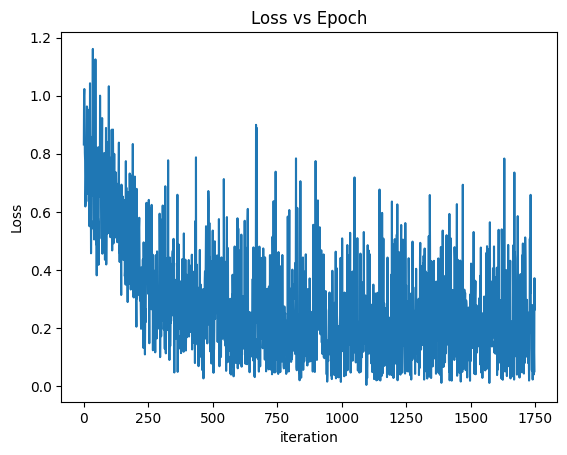

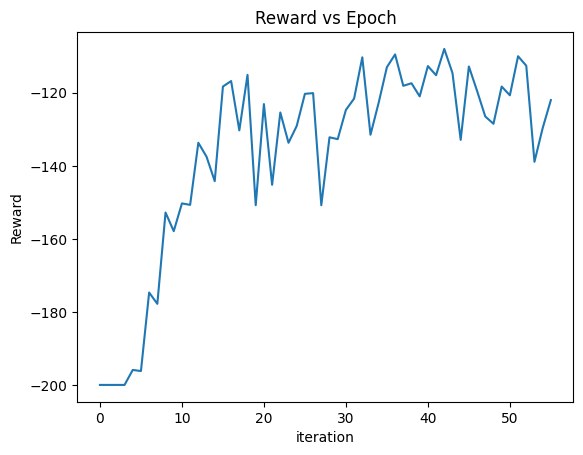

<Figure size 640x480 with 0 Axes>

In [18]:
# save to /mnt/nfs/work/albertliu/RL/CartPole-v1/BC
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()
plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/BC/loss.png")

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("iteration")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()
plt.savefig("/mnt/nfs/work/albertliu/RL/CartPole-v1/BC/reward.png")


